In [445]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    InstanceHardnessThreshold,
    NearMiss,
    NeighbourhoodCleaningRule,
    OneSidedSelection,
    TomekLinks
)
from imblearn.over_sampling import (
    SMOTE,
    ADASYN,
    BorderlineSMOTE
)
from imblearn.combine import (
    SMOTETomek,
    SMOTEENN
)
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, Normalizer
import time
import joblib

In [446]:
pd.set_option('display.max_columns', None)

### Reading data

In [447]:
file_path = 'bank-full.csv'  
df_bank = pd.read_csv(file_path, )  # The Bank Marketing dataset uses ';' as a separator
print("Bank Marketing dataset size:", df_bank.shape)

file_path = 'citrus.csv'
df_citrus = pd.read_csv(file_path)
print("Citrus dataset size:", df_citrus.shape)

Bank Marketing dataset size: (49557, 17)
Citrus dataset size: (10000, 6)


### Info

In [448]:
memory_usage = df_bank.memory_usage(deep=True).sum()
print("Memory usage of df_bank: {:.2f} MB".format(memory_usage / (1024 * 1024)))

memory_usage = df_citrus.memory_usage(deep=True).sum()
print("Memory usage of df_citrus: {:.2f} MB".format(memory_usage / (1024 * 1024)))

Memory usage of df_bank: 28.22 MB
Memory usage of df_citrus: 0.93 MB


In [449]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49557 entries, 0 to 49556
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        49557 non-null  int64 
 1   job        49557 non-null  object
 2   marital    49557 non-null  object
 3   education  49557 non-null  object
 4   default    49557 non-null  object
 5   balance    49557 non-null  int64 
 6   housing    49557 non-null  object
 7   loan       49557 non-null  object
 8   contact    49557 non-null  object
 9   day        49557 non-null  int64 
 10  month      49557 non-null  object
 11  duration   49557 non-null  int64 
 12  campaign   49557 non-null  int64 
 13  pdays      49557 non-null  int64 
 14  previous   49557 non-null  int64 
 15  poutcome   49557 non-null  object
 16  Target     49557 non-null  object
dtypes: int64(7), object(10)
memory usage: 6.4+ MB


In [450]:
df_citrus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      10000 non-null  object 
 1   diameter  10000 non-null  float64
 2   weight    10000 non-null  float64
 3   red       10000 non-null  int64  
 4   green     10000 non-null  int64  
 5   blue      10000 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


In [451]:
df_bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,49557.000000,49557.000000,49557.000000,49557.000000,49557.000000,49557.000000,49557.000000
mean,40.958028,1369.703856,15.803015,257.156143,2.757108,40.213613,0.580523
std,10.639180,3094.088213,8.330539,256.256104,3.072296,100.337370,2.273184
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,452.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1437.000000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [452]:
df_citrus.describe()

,diameter,weight,red,green,blue
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9.975685,175.050792,153.847800,76.010600,11.363200
std,1.947844,29.212119,10.432954,11.708433,9.061275
min,2.960000,86.760000,115.000000,31.000000,2.000000
25%,8.460000,152.220000,147.000000,68.000000,2.000000
50%,9.980000,174.985000,154.000000,76.000000,10.000000
75%,11.480000,197.722500,161.000000,84.000000,17.000000
max,16.450000,261.510000,192.000000,116.000000,56.000000


In [453]:
nan_counts = df_bank.isna().sum()
print("Number of NaN values in each column bank dataset:")
print(nan_counts)

Number of NaN values in each column bank dataset:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64


In [454]:
nan_counts = df_citrus.isna().sum()
print("Number of NaN values in each column citrus dataset:")
print(nan_counts)

Number of NaN values in each column citrus dataset:
name        0
diameter    0
weight      0
red         0
green       0
blue        0
dtype: int64


### Bank data meaning

In [455]:
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [456]:
target_counts = df_bank['Target'].value_counts()

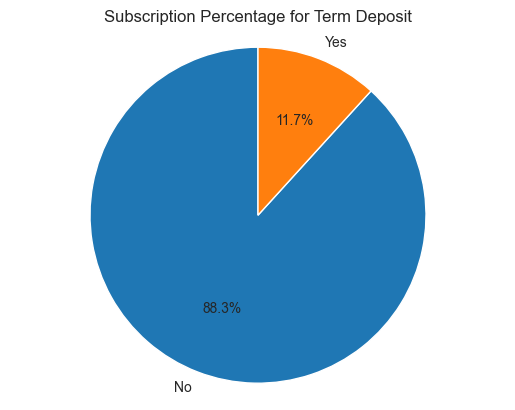

In [457]:
fig, ax = plt.subplots()
ax.pie(target_counts, labels=['No', 'Yes'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Subscription Percentage for Term Deposit')
plt.show()

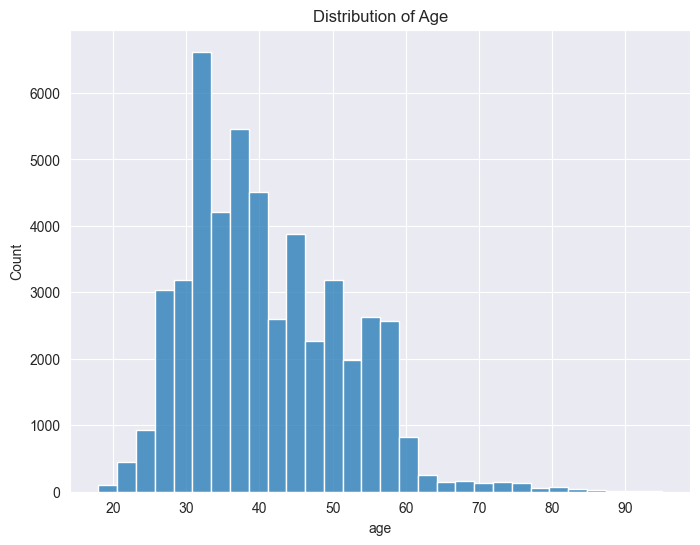

In [458]:
plt.figure(figsize=(8, 6))
sns.histplot(df_bank['age'], bins=30)
plt.title('Distribution of Age')
plt.show()

In [459]:
numeric_columns = df_bank.select_dtypes(include=['number']).columns
df_numeric = df_bank[numeric_columns]

In [460]:
corr = df_numeric.corr()

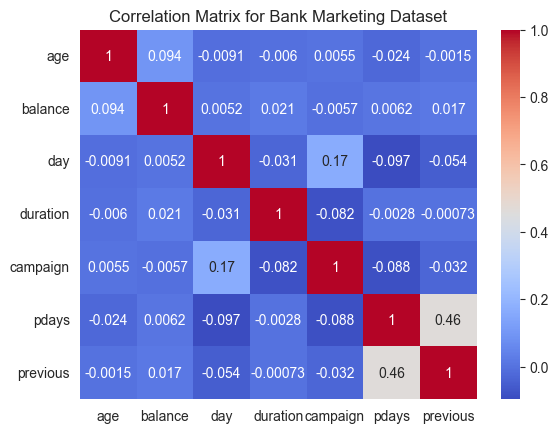

In [461]:
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Bank Marketing Dataset')
plt.show()

#### Exploring the categorical features

In [462]:
categorical_features=[feature for feature in df_bank.columns if df_bank[feature].dtypes=='O']
categorical_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'Target']

In [463]:
for feature in categorical_features:
    print("The feature is {} and the number of categories are {}".format(feature,len(df_bank[feature].unique())))

The feature is job and the number of categories are 12
The feature is marital and the number of categories are 3
The feature is education and the number of categories are 4
The feature is default and the number of categories are 2
The feature is housing and the number of categories are 2
The feature is loan and the number of categories are 2
The feature is contact and the number of categories are 3
The feature is month and the number of categories are 12
The feature is poutcome and the number of categories are 4
The feature is Target and the number of categories are 2


#### categorical distribution

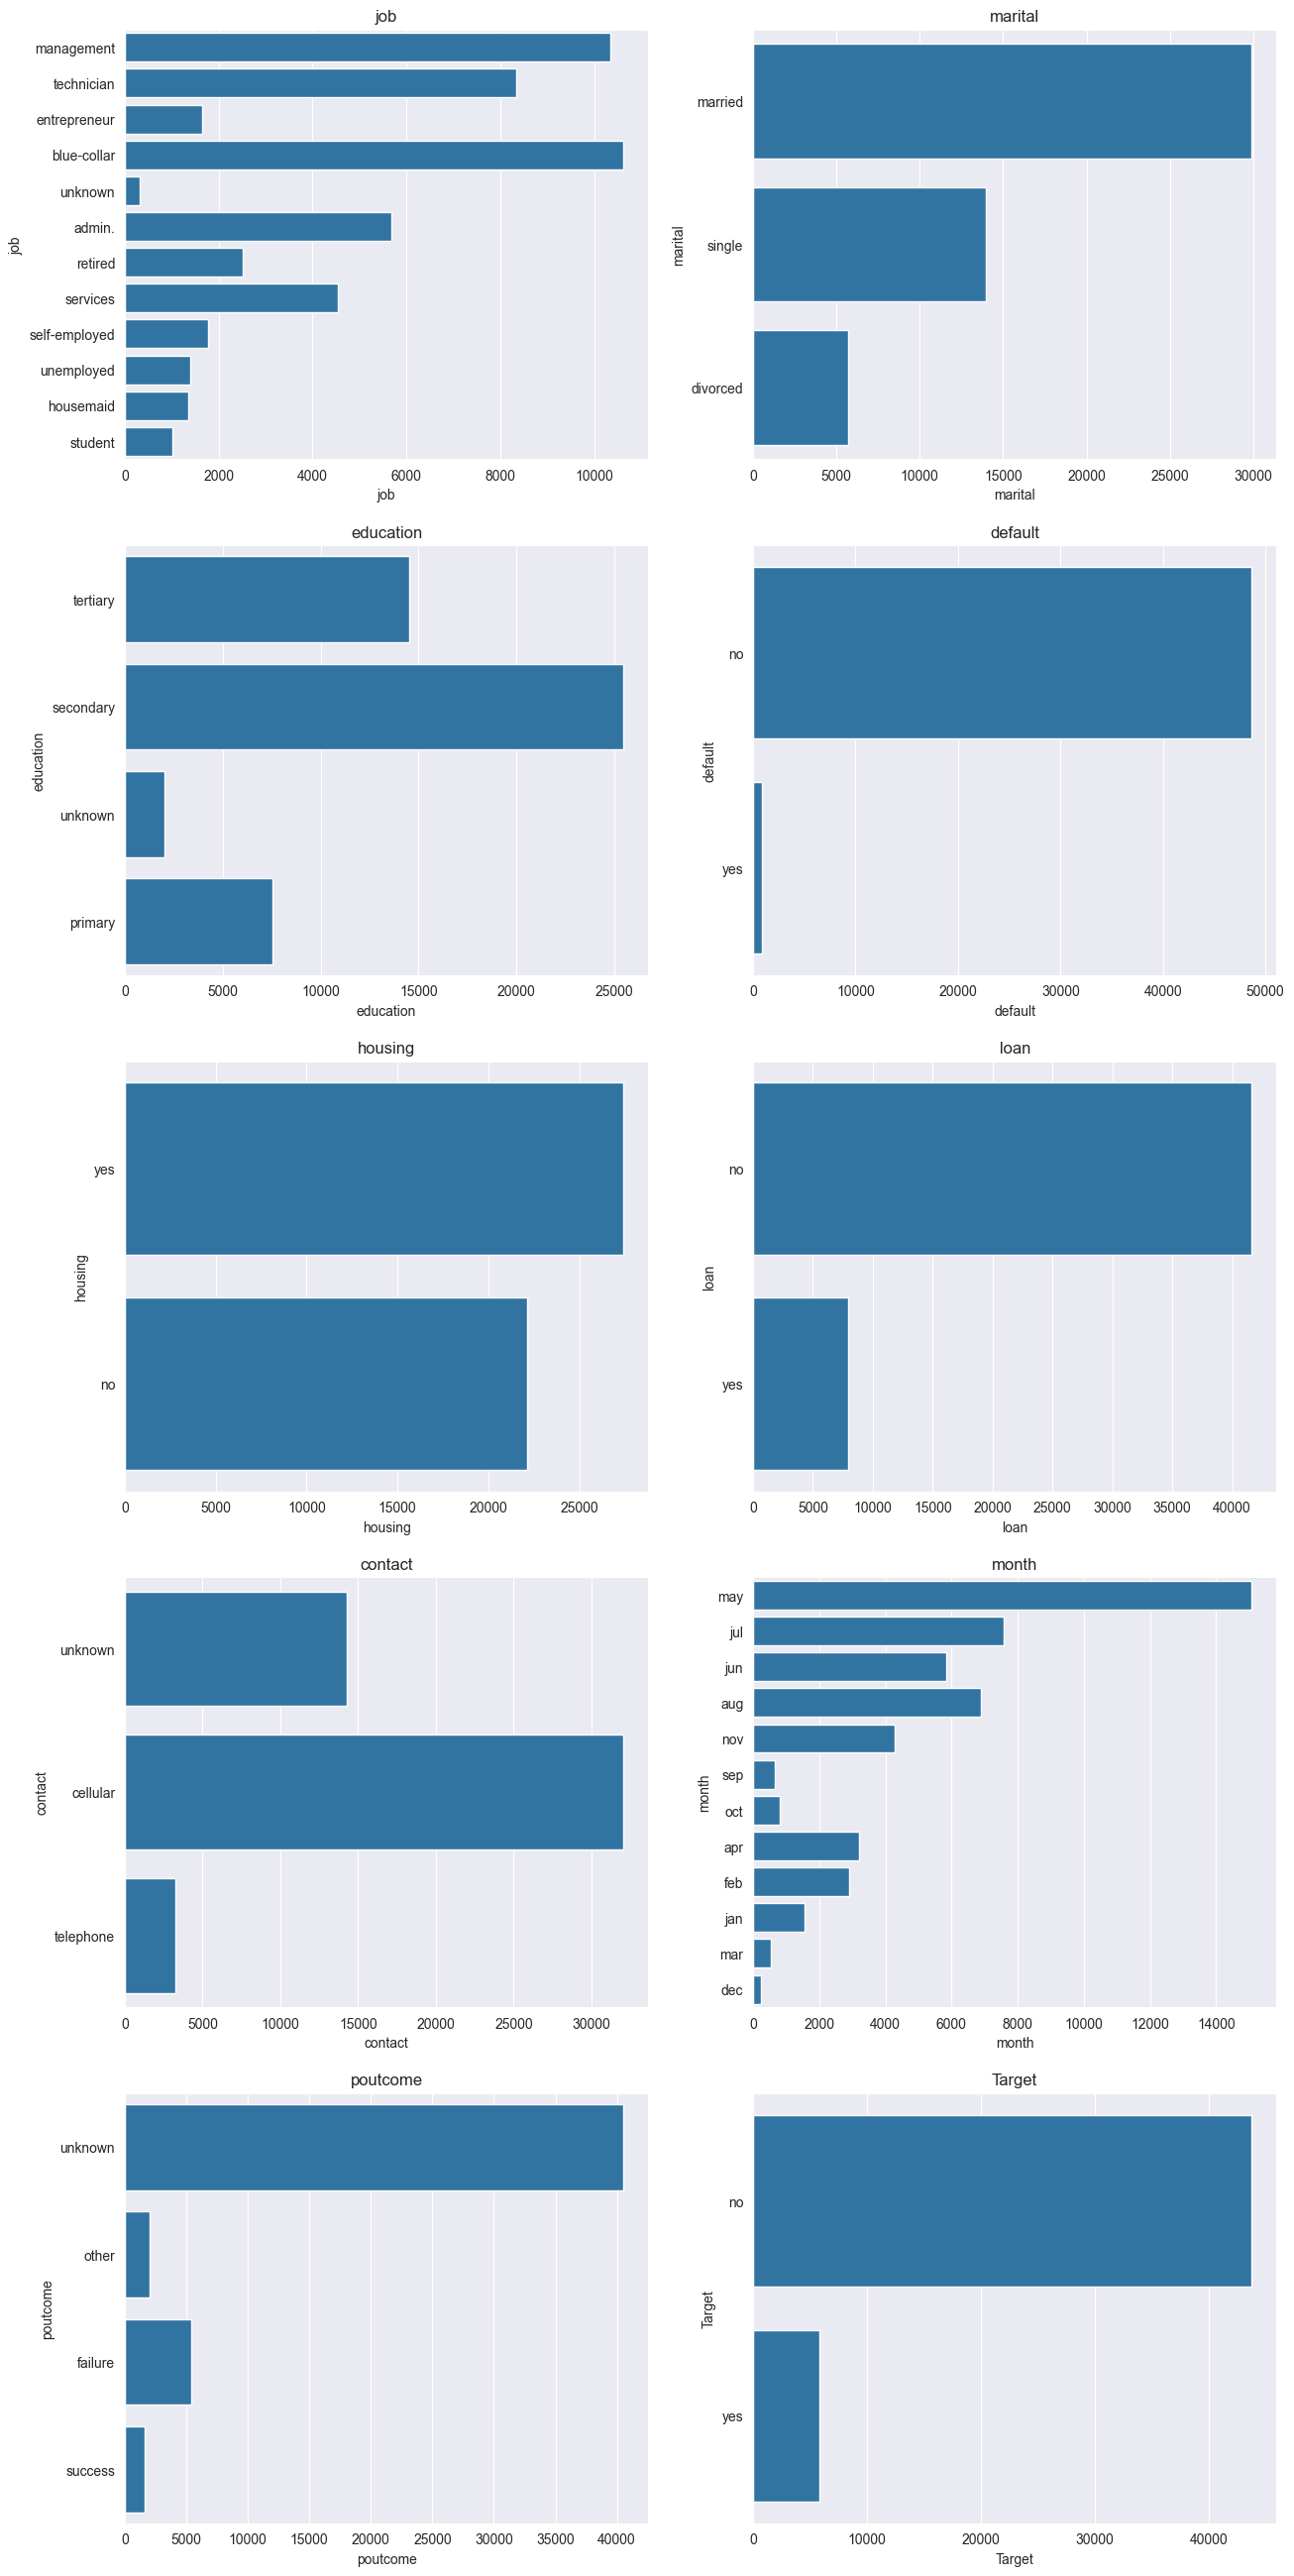

In [464]:
plt.figure(figsize=(15,80),facecolor='white')
plotnumber=1
for categorical_feature in categorical_features:
    ax=plt.subplot(12,2,plotnumber)
    sns.countplot(y=categorical_feature,data=df_bank)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature)
    plotnumber+=1
plt.show()

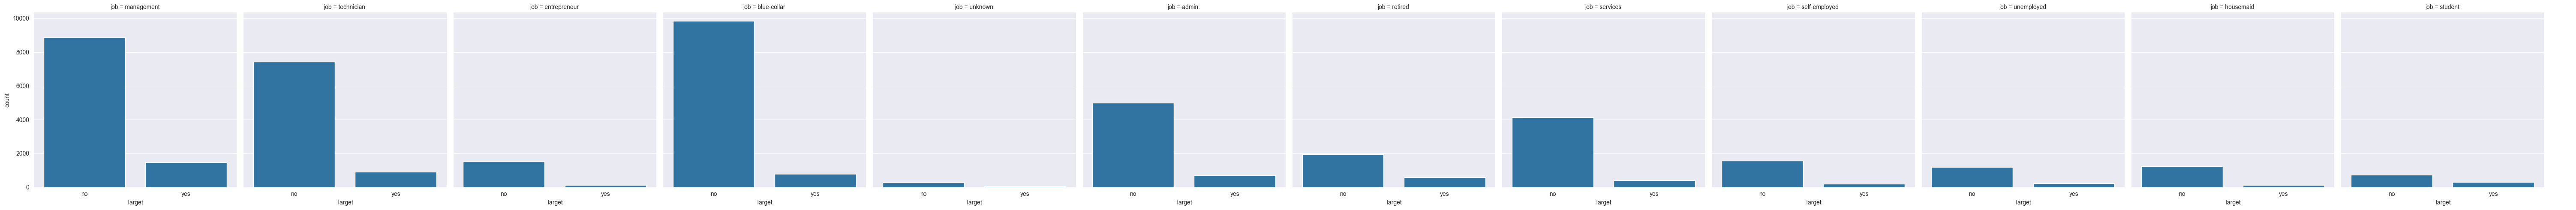

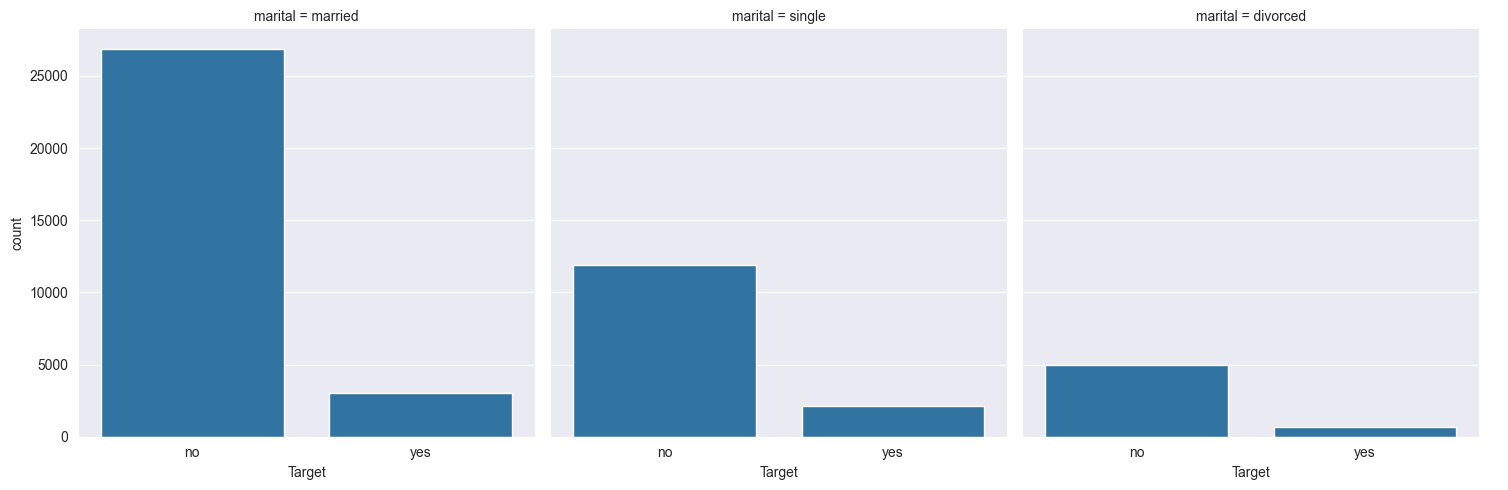

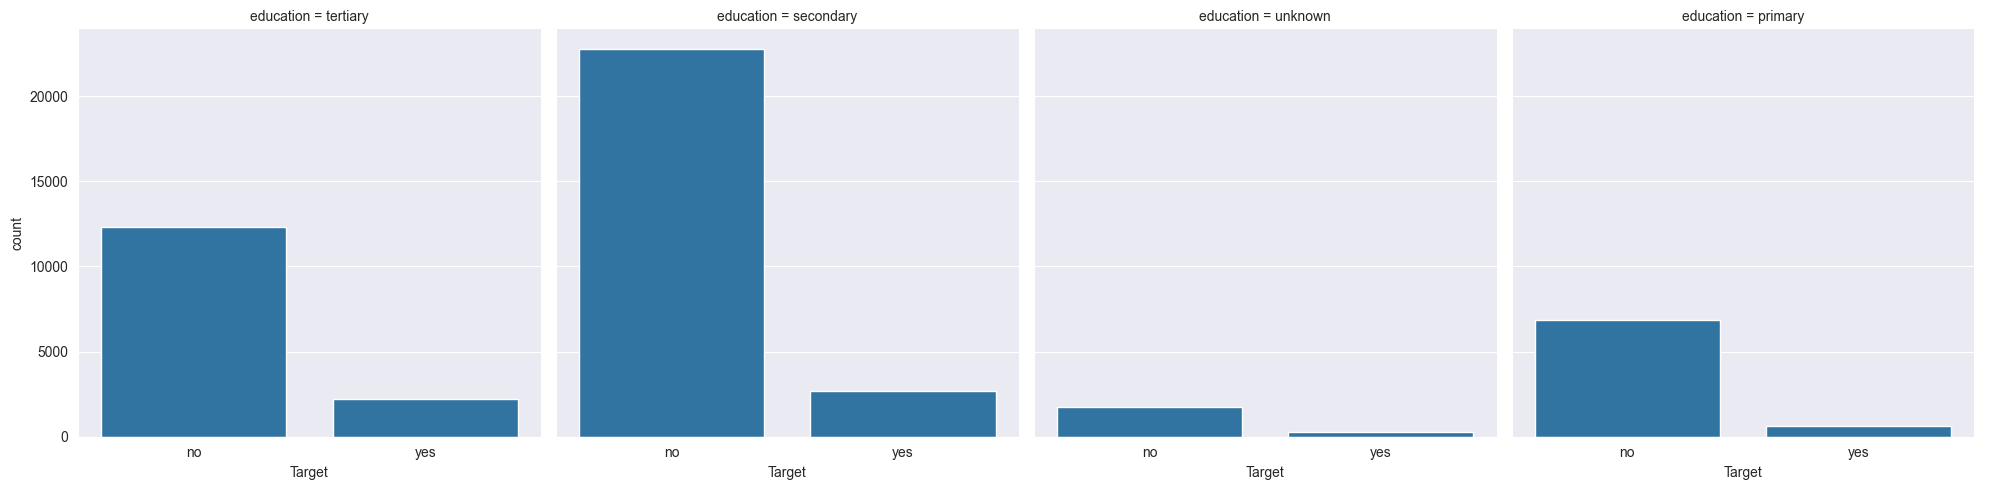

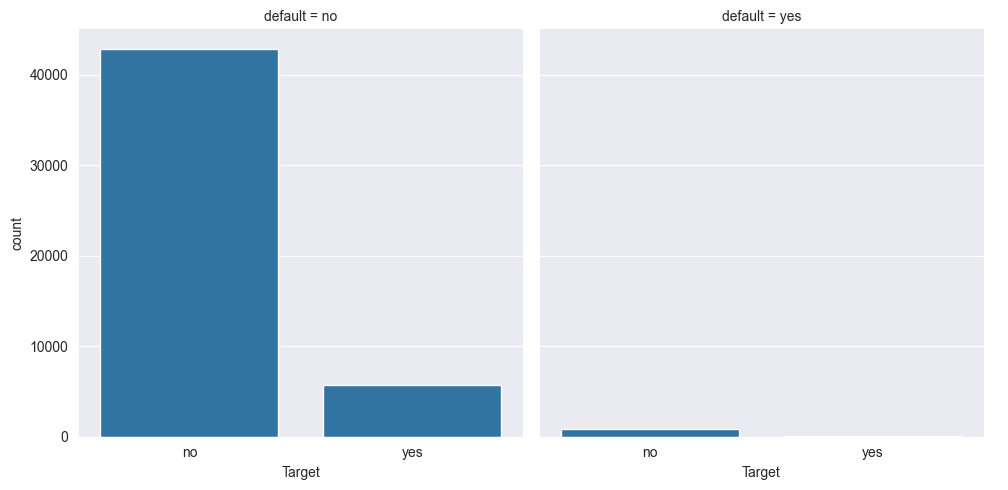

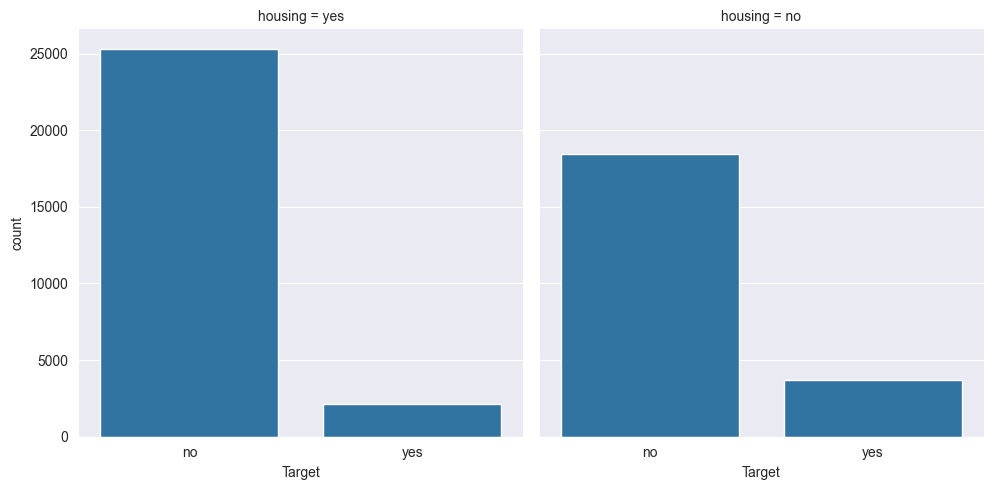

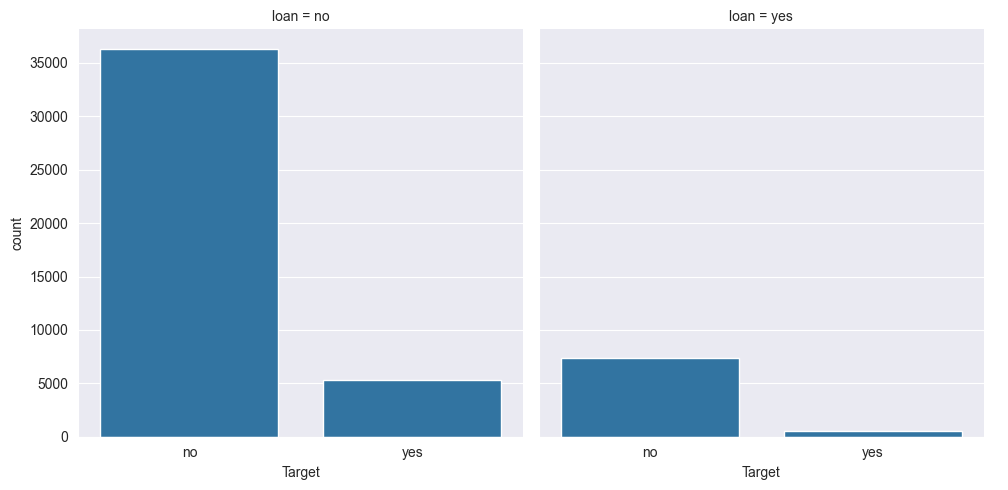

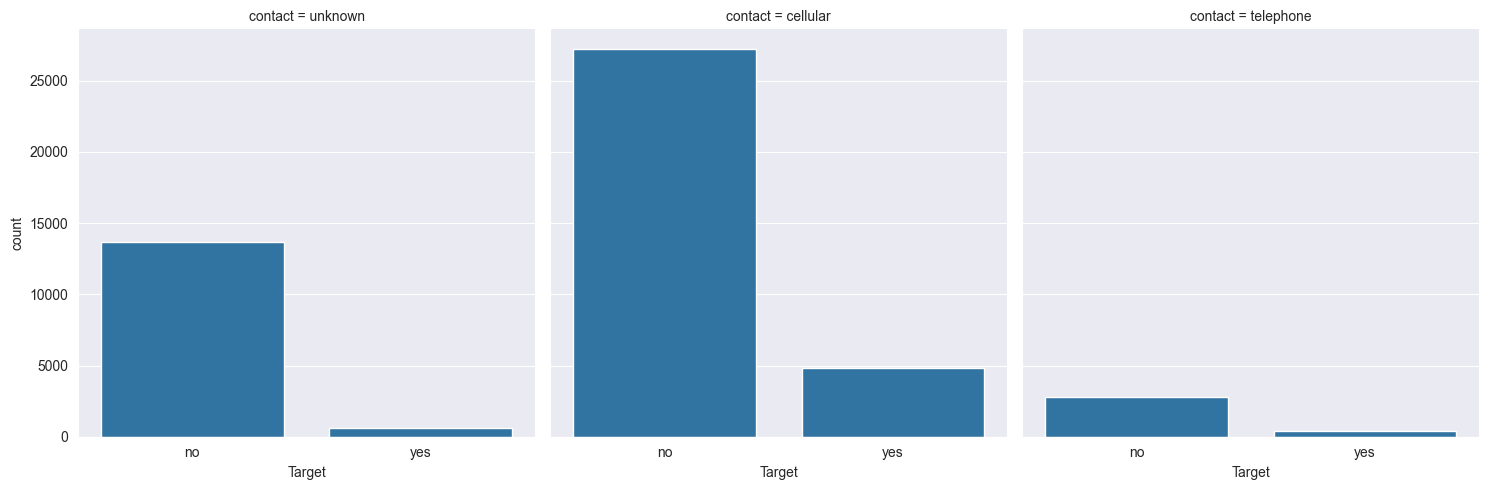

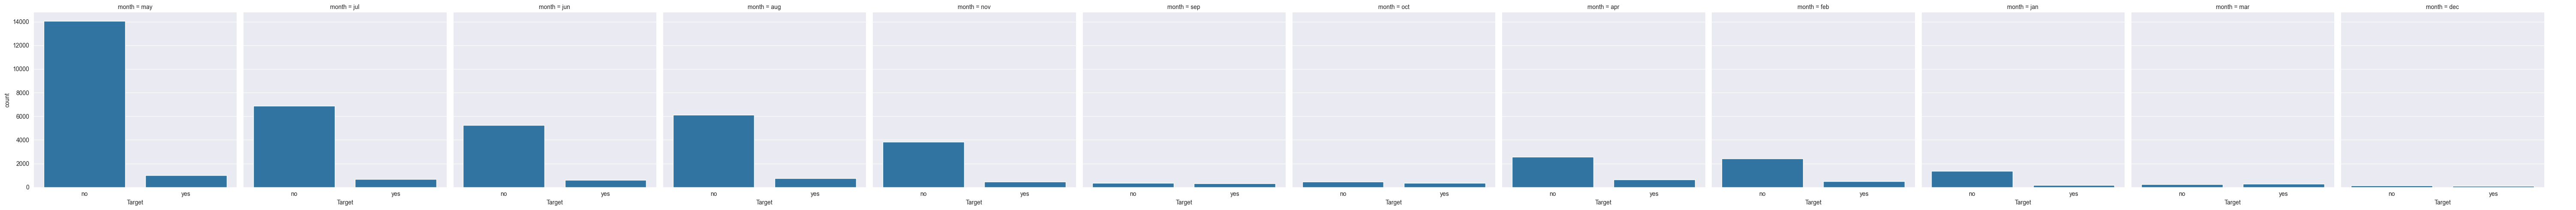

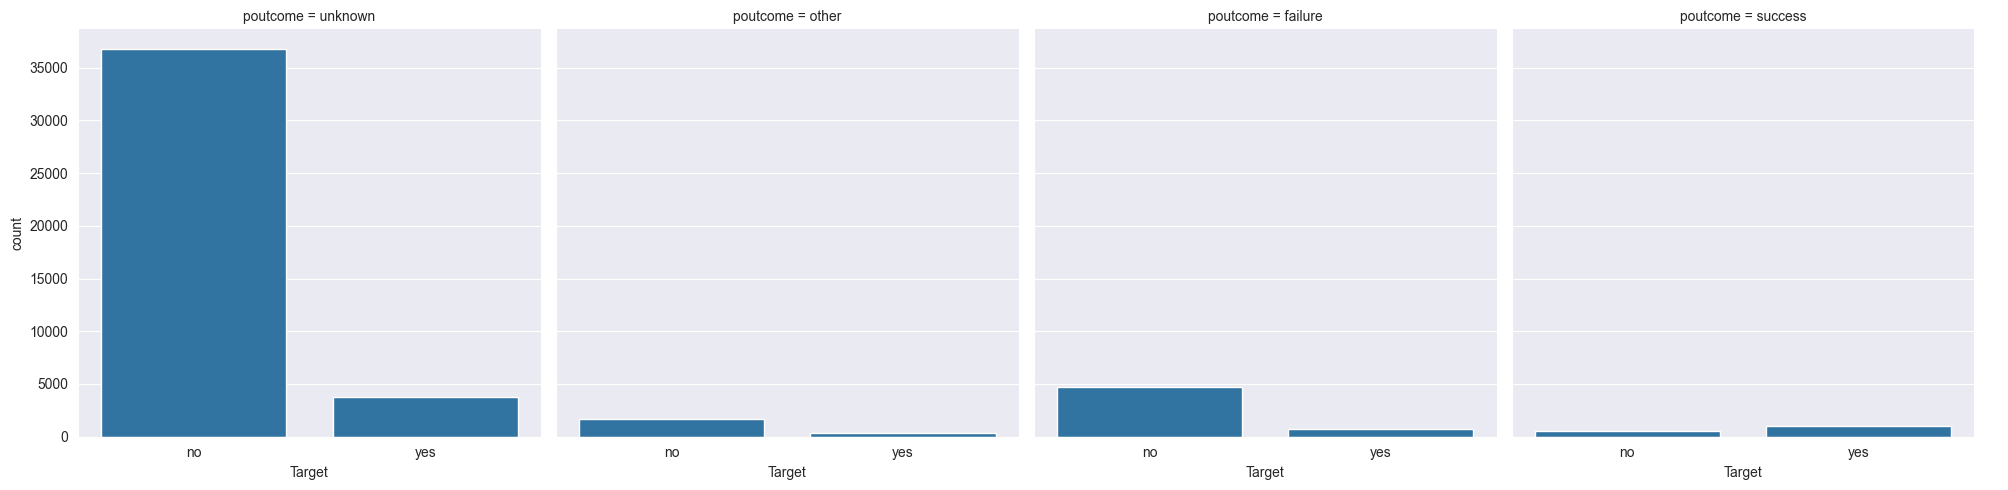

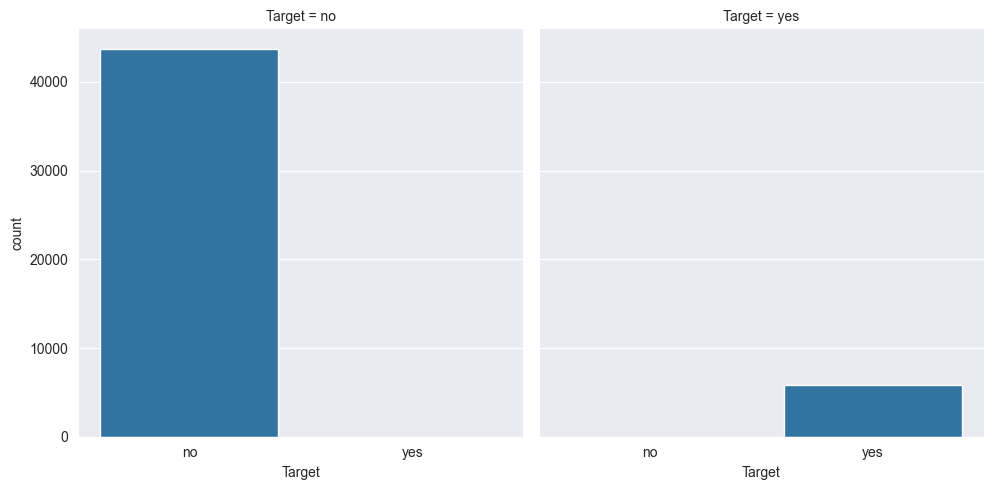

In [465]:
#firstly we have to check that out target label split over categorical features
#find out the realationship between categorical variable and dependent variable
for categorical_feature in categorical_features:
    sns.catplot(x='Target',col=categorical_feature,kind='count',data=df_bank)
plt.show()

#### Discrete features

In [466]:
discrete_features=[feature for feature in numeric_columns if len(df_bank[feature].unique())<25]
print("Discrete variables count():{}".format(len(discrete_features)))

Discrete variables count():0


#### Continues features

In [467]:
continuous_features=[feature for feature in numeric_columns if feature not in discrete_features+['Target']]
print("Continuous feature count {}".format(len(continuous_features)))

Continuous feature count 7


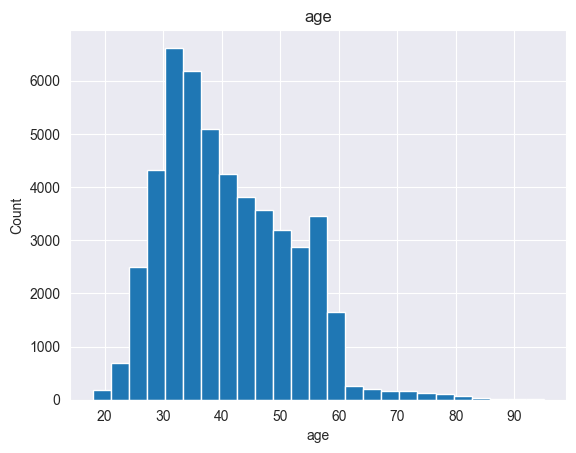

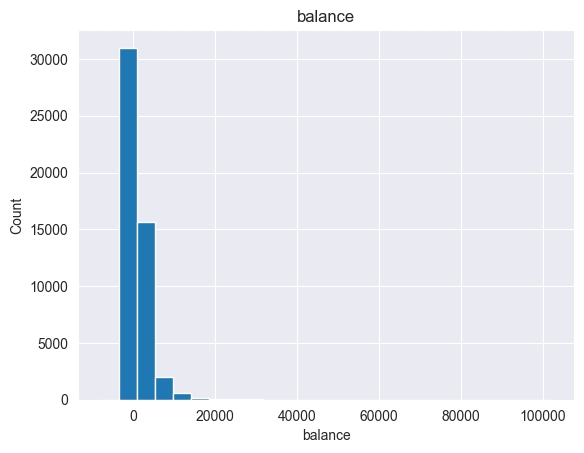

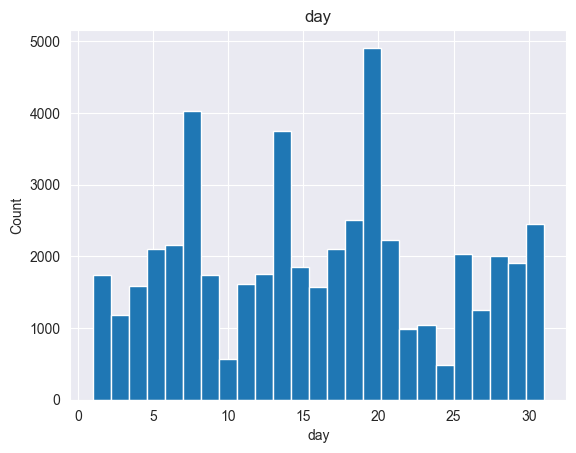

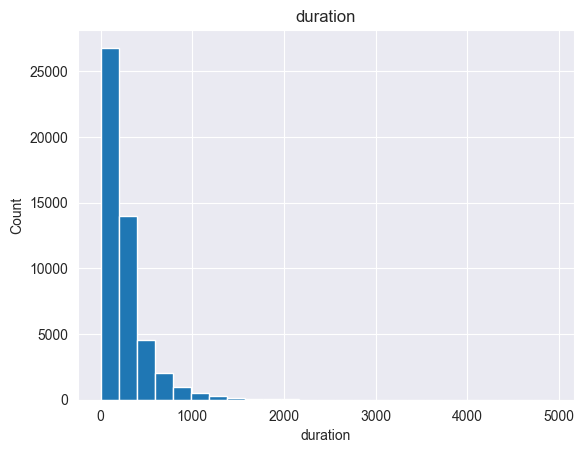

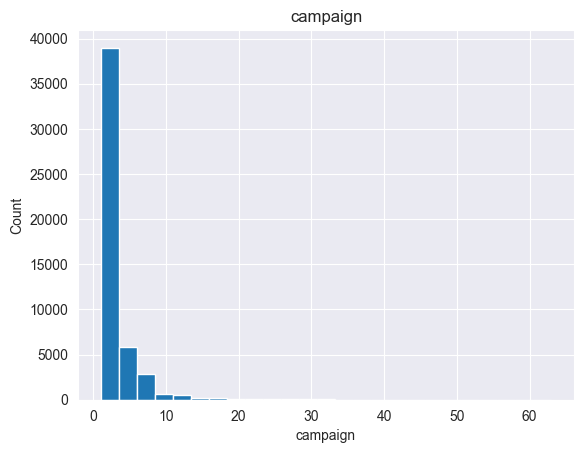

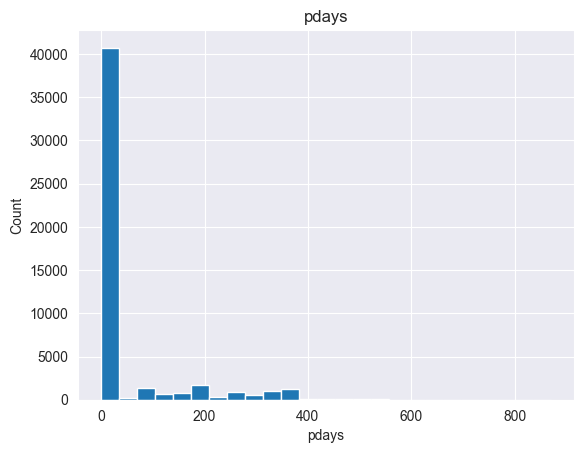

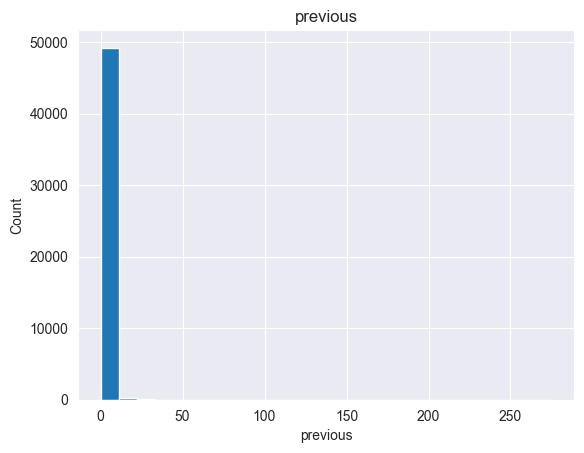

In [468]:
for feature in continuous_features:
    data=df_bank.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

#### Relation between continuous feature and labels

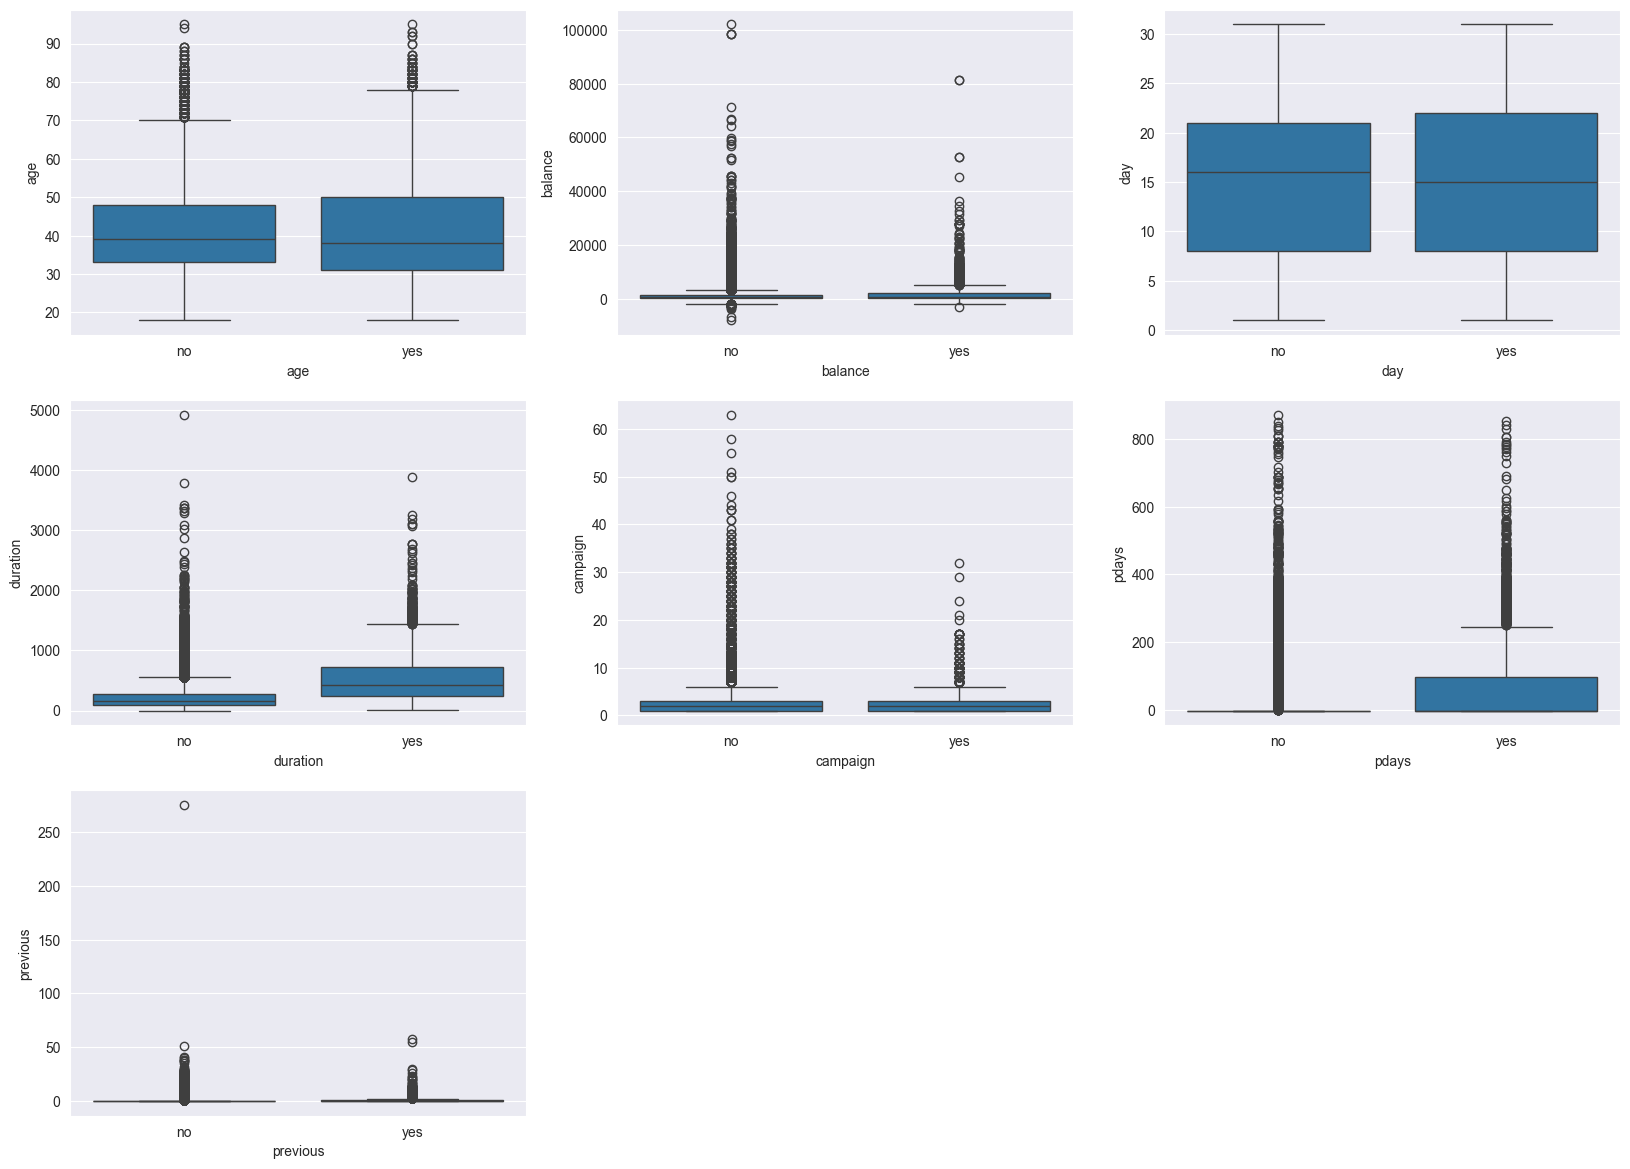

In [469]:
plt.figure(figsize=(20,60),facecolor='white')
plotnumber=1
for feature in continuous_features:
    ax=plt.subplot(12,3,plotnumber)
    sns.boxplot(x='Target',y=df_bank[feature],data=df_bank)
    plt.xlabel(feature)
    plotnumber+=1
plt.show()

#### find Outliers in numerical feature

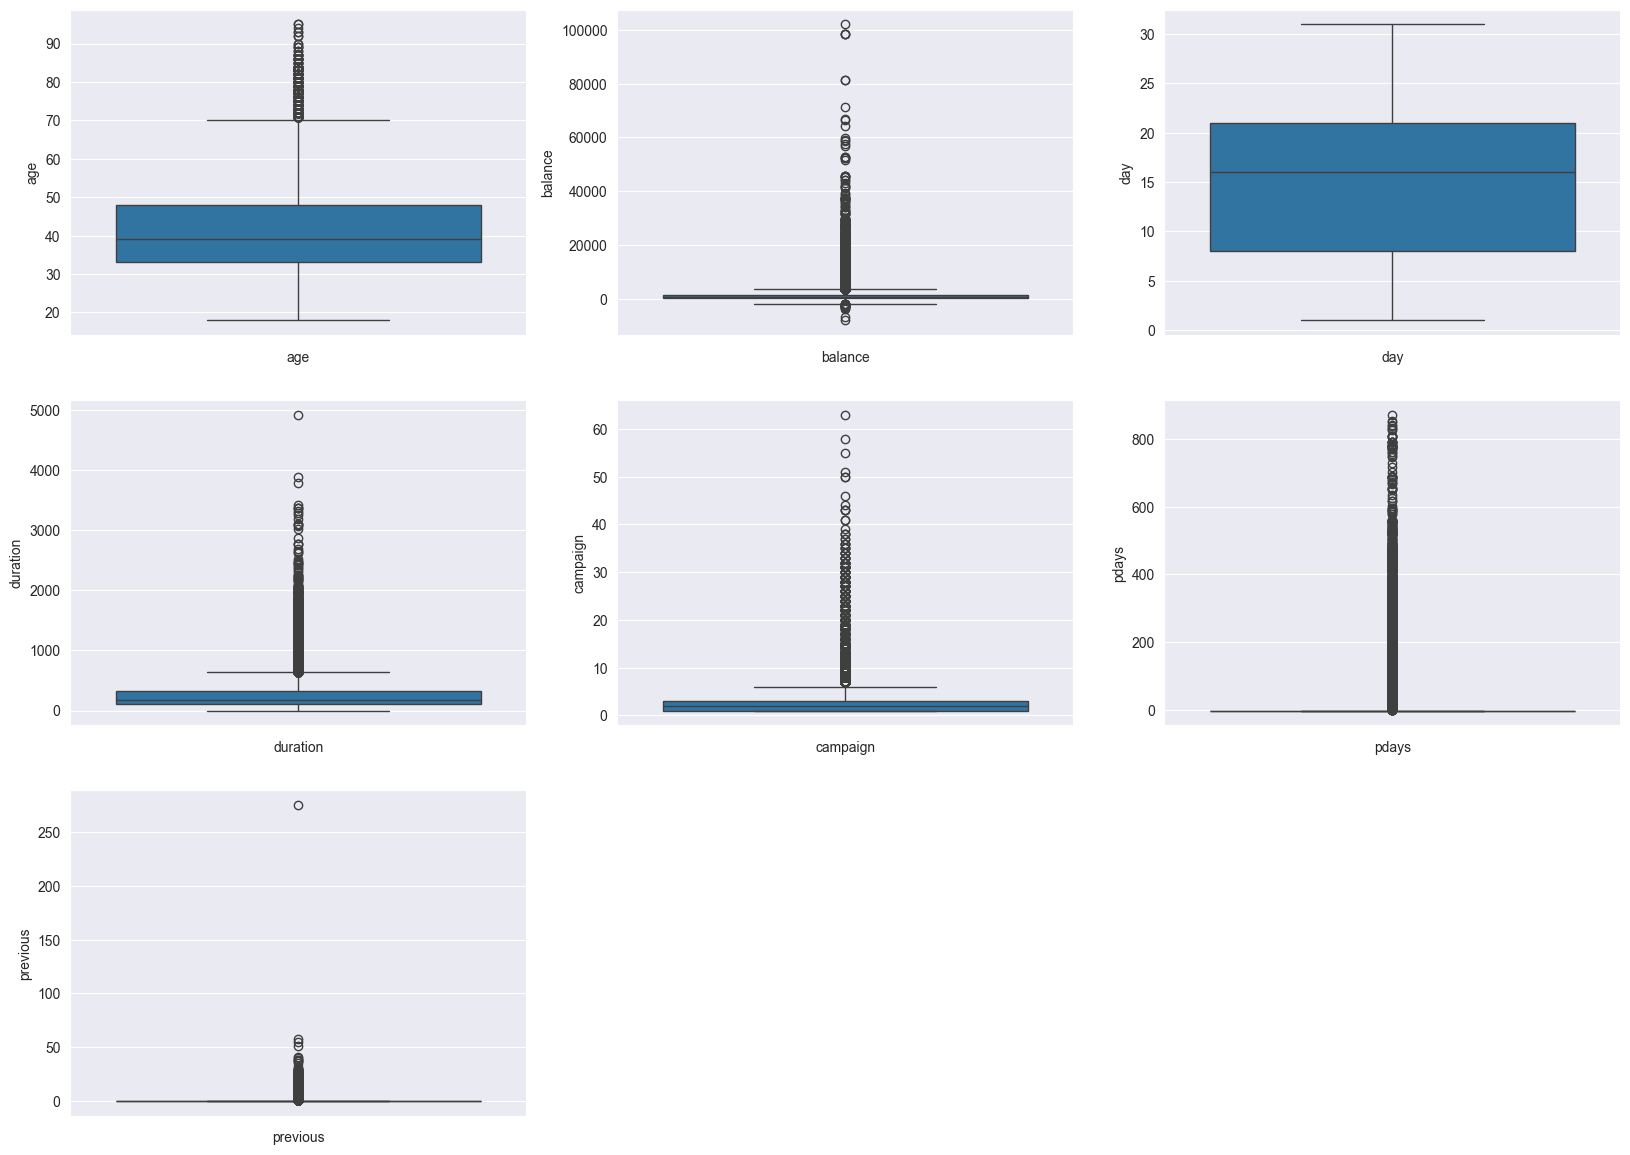

In [470]:
plt.figure(figsize=(20,60),facecolor='white')
plotnumber=1
for numerical_feature in numeric_columns:
    ax=plt.subplot(12,3,plotnumber)
    sns.boxplot(df_bank[numerical_feature])
    plt.xlabel(numerical_feature)
    plotnumber+=1
plt.show()

In [471]:
# Count the number of duplicate rows
duplicate_count = df_bank.duplicated().sum()

# Print the number of duplicates
print(f'Number of duplicate rows: {duplicate_count}')

Number of duplicate rows: 4346


### Bank data cleaning? 

There isn't removing of duplicates and outliers, beause main idea is to see if instance selection algorithms are doing that.

In [472]:
#Copying original dataframe
bank_data = df_bank.copy()

scaler=StandardScaler()
bank_data[numeric_columns]=scaler.fit_transform(bank_data[numeric_columns])
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,1.601829,management,married,tertiary,no,0.249930,yes,no,unknown,-1.29681,may,0.015000,-0.571926,-0.410755,-0.255382,unknown,no
1,0.285925,technician,single,secondary,no,-0.433316,yes,no,unknown,-1.29681,may,-0.414262,-0.571926,-0.410755,-0.255382,unknown,no
2,-0.748000,entrepreneur,married,secondary,no,-0.442042,yes,yes,unknown,-1.29681,may,-0.706941,-0.571926,-0.410755,-0.255382,unknown,no
3,0.567904,blue-collar,married,unknown,no,0.044051,yes,no,unknown,-1.29681,may,-0.644503,-0.571926,-0.410755,-0.255382,unknown,no
4,-0.748000,unknown,single,unknown,no,-0.442365,no,no,unknown,-1.29681,may,-0.230850,-0.571926,-0.410755,-0.255382,unknown,no


In [473]:

bank_data = df_bank.copy()

# Identify categorical features
categorical_features = ['job','marital','education','default','housing','loan','contact','month','poutcome']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Encode categorical data
df_encoded = pd.DataFrame(encoder.fit_transform(bank_data[categorical_features]))
df_encoded.columns = encoder.get_feature_names_out(categorical_features)

# Replace categorical data with encoded data
bank_data = bank_data.drop(categorical_features, axis=1)
bank_data = pd.concat([df_encoded, bank_data], axis=1)

# Encode target value
bank_data['Target'] = bank_data['Target'].apply(lambda x: 1 if x == 'yes' else 0)

print('Shape of the dataframe:', bank_data.shape)
print(bank_data.head())

Shape of the dataframe: (49557, 52)
   job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
0         0.0              0.0               0.0            0.0   
1         0.0              0.0               0.0            0.0   
2         0.0              0.0               1.0            0.0   
3         0.0              1.0               0.0            0.0   
4         0.0              0.0               0.0            0.0   

   job_management  job_retired  job_self-employed  job_services  job_student  \
0             1.0          0.0                0.0           0.0          0.0   
1             0.0          0.0                0.0           0.0          0.0   
2             0.0          0.0                0.0           0.0          0.0   
3             0.0          0.0                0.0           0.0          0.0   
4             0.0          0.0                0.0           0.0          0.0   

   job_technician  job_unemployed  job_unknown  marital_divorced  \
0           

### Citrus data cleaning

In [474]:
# Count the number of duplicate rows
duplicate_count = df_citrus.duplicated().sum()

# Print the number of duplicates
print(f'Number of duplicate rows citrus: {duplicate_count}')

Number of duplicate rows citrus: 0


In [475]:
# Perform label encoding on the 'name' column
label_encoder = LabelEncoder()
df_citrus['name'] = label_encoder.fit_transform(df_citrus['name'])

df_citrus.head()

,name,diameter,weight,red,green,blue
0,1,2.96,86.76,172,85,2
1,1,3.91,88.05,166,78,3
2,1,4.42,95.17,156,81,2
3,1,4.47,95.60,163,81,4
4,1,4.48,95.76,161,72,9


## Algorithms

In [476]:
def under_sampling_evaluation(X, y):
    # Define under-sampling techniques
    under_sampling_techniques = [
        ("Original", None),
        ("CondensedNN", CondensedNearestNeighbour(random_state=42, n_neighbors=1, n_seeds_S=1, n_jobs=-1)),
        ("NeighbourhoodCleaningRule", NeighbourhoodCleaningRule(n_jobs=-1)),
        ("TomekLinks", TomekLinks(n_jobs=-1)),
        ("EditedNearestNeighbours", EditedNearestNeighbours(n_jobs=-1)),
    ]

    # Scale and normalize the data
    X_scaled = StandardScaler().fit_transform(X)
    X_normalized = Normalizer().fit_transform(X_scaled)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    X_train_df = pd.DataFrame(X_train, columns=X.columns)

    results = {}

    for technique_name, technique in under_sampling_techniques:
        start_time = time.time()
        
        # Apply under-sampling technique to the train set
        if technique:
            # Limit the number of instances to 3000 for CondensedNearestNeighbour algorithm
            if technique_name == "CondensedNN" and X_train.shape[0] > 3000:
                X_train_resampled, y_train_resampled = technique.fit_resample(X_train[:3000], y_train[:3000])
            else:
                X_train_resampled, y_train_resampled = technique.fit_resample(X_train, y_train)
        else:
            X_train_resampled, y_train_resampled = X_train, y_train

        num_instances_start = X_train.shape[0]
        num_instances_end = X_train_resampled.shape[0]
        percentage_instances_end = (num_instances_end / num_instances_start) * 100

        num_duplicated_start = X_train_df.duplicated().sum()
        num_duplicated_end = pd.DataFrame(X_train_resampled, columns=X.columns).duplicated().sum()

        # Train a k-NN classifier and evaluate the results
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train_resampled, y_train_resampled)

        y_pred = knn.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        elapsed_time = time.time() - start_time

        # Save the results in a dictionary
        results[technique_name] = {
            "time": elapsed_time,
            "accuracy": accuracy,
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1-score": report["weighted avg"]["f1-score"],
            "num_instances_start": num_instances_start,
            "num_instances_end": num_instances_end,
            "percentage_instances_end": percentage_instances_end,
            "num_duplicated_start": num_duplicated_start,
            "num_duplicated_end": num_duplicated_end,
        }

    results_df = pd.DataFrame(results).T
    sorted_results = results_df.sort_values(by=["time", "accuracy", "num_instances_end"], ascending=[True, False, True])

    return sorted_results.head(10)

In [477]:
X = df_citrus.drop('name', axis=1)  # Feature columns
y = df_citrus['name']  # Target column
under_sampling_evaluation(X, y)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
TomekLinks,0.165011,0.916,0.916067,0.916,0.915989,8000.0,7764.0,97.0500,0.0,0.0
EditedNearestNeighbours,0.172846,0.914,0.917002,0.914,0.913796,8000.0,7196.0,89.9500,0.0,0.0
Original,0.207358,0.918,0.918035,0.918,0.918003,8000.0,8000.0,100.0000,0.0,0.0
NeighbourhoodCleaningRule,0.573782,0.913,0.914741,0.913,0.912871,8000.0,7304.0,91.3000,0.0,0.0
CondensedNN,31.905819,0.905,0.907436,0.905,0.904906,8000.0,1763.0,22.0375,0.0,0.0


In [478]:
X = bank_data.drop('Target', axis=1)  # Feature columns
y = bank_data['Target']  # Target column
under_sampling_evaluation(X, y)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
Original,2.922277,0.898204,0.886839,0.898204,0.890387,39645.0,39645.0,100.000000,3058.0,3058.0
CondensedNN,6.158427,0.842111,0.863189,0.842111,0.851275,39645.0,893.0,2.252491,3058.0,6.0
EditedNearestNeighbours,7.416336,0.884282,0.892186,0.884282,0.887810,39645.0,35160.0,88.687098,3058.0,2858.0
TomekLinks,8.214317,0.896691,0.888511,0.896691,0.891715,39645.0,38677.0,97.558330,3058.0,3058.0
NeighbourhoodCleaningRule,10.245007,0.886098,0.892402,0.886098,0.888965,39645.0,34209.0,86.288309,3058.0,2703.0


### Improved function for comparing of algorithms

In [479]:
from imblearn.under_sampling import (
    CondensedNearestNeighbour,
    NeighbourhoodCleaningRule,
    TomekLinks,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    InstanceHardnessThreshold,
)

def evaluate_under_sampling_technique(X, y, technique_name):
    # Map technique name to the actual technique object
    techniques = {
        "Original": None,
        "CNN": CondensedNearestNeighbour(random_state=42, n_neighbors=1, n_seeds_S=1, n_jobs=-1),
        "TomekLinks": TomekLinks(n_jobs=-1),
        "ENN": EditedNearestNeighbours(n_jobs=-1),
        "RENN": RepeatedEditedNearestNeighbours(n_jobs=-1),
        "NCR": NeighbourhoodCleaningRule(n_jobs=-1),
        "IHT": InstanceHardnessThreshold(random_state=42, n_jobs=-1),
    }

    technique = techniques.get(technique_name)

    # Scale and normalize the data
    X_scaled = StandardScaler().fit_transform(X)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    X_train_df = pd.DataFrame(X_train, columns=X.columns)

    results = {}

    start_time = time.time()

    # Apply under-sampling technique to the train set
    if technique:
        # Limit the number of instances to 3000 for CondensedNearestNeighbour algorithm
        if technique_name == "CNN" and X_train.shape[0] > 3000:
            X_train_resampled, y_train_resampled = technique.fit_resample(X_train[:3000], y_train[:3000])
            num_instances_start = 3000
        else:
            X_train_resampled, y_train_resampled = technique.fit_resample(X_train, y_train)
            num_instances_start = X_train.shape[0]
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
        num_instances_start = X_train.shape[0]

    num_instances_end = X_train_resampled.shape[0]
    percentage_instances_end = (num_instances_end / num_instances_start) * 100

    num_duplicated_start = X_train_df.duplicated().sum()
    num_duplicated_end = pd.DataFrame(X_train_resampled, columns=X.columns).duplicated().sum()

    # Train a k-NN classifier and evaluate the results
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_resampled, y_train_resampled)

    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    elapsed_time = time.time() - start_time

    # Save the results in a dictionary
    results[technique_name] = {
        "time": elapsed_time,
        "accuracy": accuracy,
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1-score": report["weighted avg"]["f1-score"],
        "num_instances_start": num_instances_start,
        "num_instances_end": num_instances_end,
        "percentage_instances_end": percentage_instances_end,
        "num_duplicated_start": num_duplicated_start,
        "num_duplicated_end": num_duplicated_end,
    }

    results_df = pd.DataFrame(results).T
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)
    full_dataset = pd.concat([X_train_resampled, y_train_resampled], axis=1)
    return results_df.head(10), full_dataset

In [480]:
X_bank = bank_data.drop('Target', axis=1)  # Feature columns
y_bank = bank_data.Target  # Target column

results_original_bank, _ = evaluate_under_sampling_technique(X_bank, y_bank, "Original")
results_bank=results_original_bank
results_bank.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
Original,4.063964,0.898204,0.886839,0.898204,0.890387,39645.0,39645.0,100.0,3058.0,3058.0


In [481]:
X_citrus = df_citrus.drop('name', axis=1)  # Feature columns
y_citrus = df_citrus['name']  # Target column
results_original_citrus, _ = evaluate_under_sampling_technique(X_citrus, y_citrus, "Original")
results_citrus=results_original_citrus
results_citrus.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
Original,0.147799,0.918,0.918035,0.918,0.918003,8000.0,8000.0,100.0,0.0,0.0


### Condensed Nearest Neighbour - Condensation

In [482]:
results_CNN, resulting_dataset_CNN = evaluate_under_sampling_technique(X_bank, y_bank, "CNN")
results_bank = pd.concat([results_CNN,results_bank], axis=0)
results_CNN.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
CNN,7.647807,0.842111,0.863189,0.842111,0.851275,3000.0,893.0,29.766667,3058.0,6.0


In [483]:
results_bank.head()

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
CNN,7.647807,0.842111,0.863189,0.842111,0.851275,3000.0,893.0,29.766667,3058.0,6.0
Original,4.063964,0.898204,0.886839,0.898204,0.890387,39645.0,39645.0,100.000000,3058.0,3058.0


In [484]:
resulting_dataset_CNN = pd.DataFrame(resulting_dataset_CNN, columns=X_bank.columns)
duplicate_count = resulting_dataset_CNN.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_count}')

Number of duplicate rows: 6


The trick is for algorithm to actually find duplicate rows.

In [485]:
results_CNN_citrus, resulting_dataset_citrus_CNN = evaluate_under_sampling_technique(X_citrus, y_citrus, "CNN")
results_citrus = pd.concat([results_CNN_citrus,results_citrus], axis=0)
results_CNN_citrus.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
CNN,31.438765,0.905,0.907436,0.905,0.904906,3000.0,1763.0,58.766667,0.0,0.0


In [486]:
results_citrus.head()

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
CNN,31.438765,0.905,0.907436,0.905,0.904906,3000.0,1763.0,58.766667,0.0,0.0
Original,0.147799,0.918,0.918035,0.918,0.918003,8000.0,8000.0,100.000000,0.0,0.0


In [487]:
resulting_dataset_citrus_CNN.head()

,diameter,weight,red,green,blue,name
0,1.434640,1.445678,-0.081266,-0.086318,1.284299,0
1,0.284593,0.246116,0.398009,-0.171731,0.291011,0
2,0.495093,0.484385,-1.135670,1.536525,-1.033372,0
3,0.212715,0.171828,-0.464686,-1.025859,0.732472,0
4,1.239543,1.233769,-1.327380,0.255333,1.836125,0


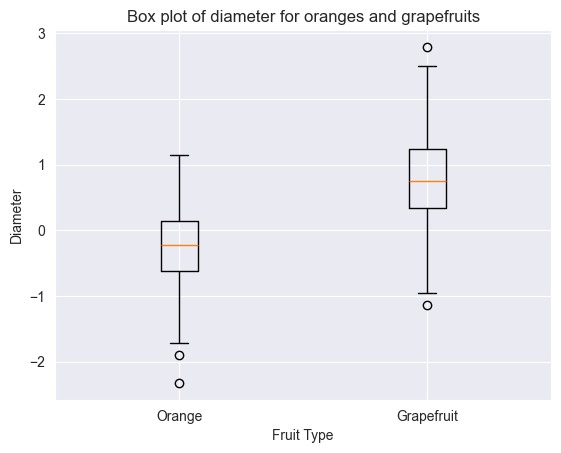

In [488]:
orange_data = resulting_dataset_citrus_CNN[resulting_dataset_citrus_CNN['name'] == 1]
grapefruit_data = resulting_dataset_citrus_CNN[resulting_dataset_citrus_CNN['name'] == 0]

plt.boxplot([orange_data['diameter'], grapefruit_data['diameter']])
plt.xticks([1, 2], ['Orange', 'Grapefruit'])
plt.xlabel('Fruit Type')
plt.ylabel('Diameter')
plt.title('Box plot of diameter for oranges and grapefruits')
plt.show()

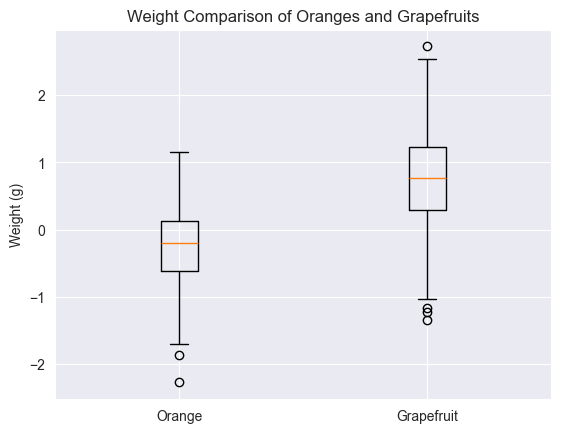

In [489]:
orange_data = resulting_dataset_citrus_CNN[resulting_dataset_citrus_CNN['name'] == 1]
grapefruit_data = resulting_dataset_citrus_CNN[resulting_dataset_citrus_CNN['name'] == 0]

plt.boxplot([orange_data['weight'], grapefruit_data['weight']])
plt.xticks([1, 2], ['Orange', 'Grapefruit'])
plt.ylabel('Weight (g)')
plt.title('Weight Comparison of Oranges and Grapefruits')
plt.show()

### NeighbourhoodCleaningRule 

In [490]:
results_NCR, resulting_dataset_NCR = evaluate_under_sampling_technique(X_bank, y_bank, "NCR")
results_bank = pd.concat([results_NCR,results_bank], axis=0)
results_NCR.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
NCR,11.187372,0.886098,0.892402,0.886098,0.888965,39645.0,34209.0,86.288309,3058.0,2703.0


In [491]:
results_citrus_NCR, resulting_dataset_citrus_NCR = evaluate_under_sampling_technique(X_citrus, y_citrus, "NCR")
results_citrus = pd.concat([results_citrus_NCR,results_citrus], axis=0)
results_citrus_NCR.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
NCR,1.336665,0.913,0.914741,0.913,0.912871,8000.0,7304.0,91.3,0.0,0.0


In [492]:
results_citrus.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
NCR,1.336665,0.913,0.914741,0.913,0.912871,8000.0,7304.0,91.300000,0.0,0.0
CNN,31.438765,0.905,0.907436,0.905,0.904906,3000.0,1763.0,58.766667,0.0,0.0
Original,0.147799,0.918,0.918035,0.918,0.918003,8000.0,8000.0,100.000000,0.0,0.0


### Tomek links

In [493]:
results_tomek, resulting_dataset_tomek = evaluate_under_sampling_technique(X_bank, y_bank, "TomekLinks")
results_bank = pd.concat([results_tomek,results_bank], axis=0)
results_tomek.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
TomekLinks,10.498731,0.896691,0.888511,0.896691,0.891715,39645.0,38677.0,97.55833,3058.0,3058.0


In [494]:
results_tomek_citrus, resulting_dataset_citrus_tomek = evaluate_under_sampling_technique(X_citrus, y_citrus, "TomekLinks")
results_citrus = pd.concat([results_tomek_citrus,results_citrus], axis=0)
results_tomek_citrus.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
TomekLinks,0.200511,0.916,0.916067,0.916,0.915989,8000.0,7764.0,97.05,0.0,0.0


### Edited nearest neighbour - Edition

In [495]:
results_ENN, resulting_dataset_ENN = evaluate_under_sampling_technique(X_bank, y_bank, "ENN")
results_bank = pd.concat([results_ENN,results_bank], axis=0)
results_ENN.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
ENN,8.879491,0.884282,0.892186,0.884282,0.88781,39645.0,35160.0,88.687098,3058.0,2858.0


In [496]:
resulting_dataset_ENN=pd.DataFrame(resulting_dataset_ENN, columns=X_bank.columns)
duplicate_count = resulting_dataset_ENN.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_count}')

Number of duplicate rows: 2858


In [497]:
results_ENN_citrus, resulting_dataset_citrus_ENN = evaluate_under_sampling_technique(X_citrus, y_citrus, "ENN")
results_citrus = pd.concat([results_ENN_citrus,results_citrus], axis=0)
results_ENN_citrus.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
ENN,0.198665,0.914,0.917002,0.914,0.913796,8000.0,7196.0,89.95,0.0,0.0


### SMOTEENN - Hybrid

In [498]:
results_smoteenn, resulting_dataset_SMOTEENN = evaluate_under_sampling_technique(X_bank, y_bank, "RENN")
results_bank = pd.concat([results_bank,results_smoteenn], axis=0)
results_smoteenn.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
RENN,39.100698,0.871772,0.890512,0.871772,0.879411,39645.0,34045.0,85.874637,3058.0,2814.0


In [499]:
resulting_dataset_SMOTEENN=pd.DataFrame(resulting_dataset_SMOTEENN, columns=X_bank.columns)
duplicate_count = resulting_dataset_SMOTEENN.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_count}')

Number of duplicate rows: 2814


In [500]:
results_smoteenn_citrus, resulting_dataset_citrus_SMOTEENN = evaluate_under_sampling_technique(X_citrus, y_citrus, "RENN")
results_citrus = pd.concat([results_smoteenn_citrus,results_citrus], axis=0)
results_smoteenn_citrus.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
RENN,0.179873,0.914,0.917002,0.914,0.913796,8000.0,7196.0,89.95,0.0,0.0


In [501]:
results_citrus.head()

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
RENN,0.179873,0.914,0.917002,0.914,0.913796,8000.0,7196.0,89.950000,0.0,0.0
ENN,0.198665,0.914,0.917002,0.914,0.913796,8000.0,7196.0,89.950000,0.0,0.0
TomekLinks,0.200511,0.916,0.916067,0.916,0.915989,8000.0,7764.0,97.050000,0.0,0.0
NCR,1.336665,0.913,0.914741,0.913,0.912871,8000.0,7304.0,91.300000,0.0,0.0
CNN,31.438765,0.905,0.907436,0.905,0.904906,3000.0,1763.0,58.766667,0.0,0.0


Claude

In [502]:
results_IHT_bank, resulting_dataset_IHT_bank = evaluate_under_sampling_technique(X_bank, y_bank, "IHT")
results_bank = pd.concat([results_IHT_bank, results_bank], axis=0)
print("Results for IHT on bank dataset:")
print(results_IHT_bank.head(10))

Results for IHT on bank dataset:
          time  accuracy  precision    recall  f1-score  num_instances_start  \
IHT  17.673051  0.816586   0.897802  0.816586  0.842368              39645.0   

     num_instances_end  percentage_instances_end  num_duplicated_start  \
IHT            17365.0                 43.801236                3058.0   

     num_duplicated_end  
IHT              1672.0  


In [503]:
results_IHT_citrus, resulting_dataset_IHT_citrus = evaluate_under_sampling_technique(X_citrus, y_citrus, "IHT")
results_citrus = pd.concat([results_IHT_citrus, results_citrus], axis=0)
print("\nResults for IHT on citrus dataset:")
print(results_IHT_citrus.head(10))


Results for IHT on citrus dataset:
         time  accuracy  precision  recall  f1-score  num_instances_start  \
IHT  1.924053     0.919   0.919021   0.919  0.919002               8000.0   

     num_instances_end  percentage_instances_end  num_duplicated_start  \
IHT             7979.0                   99.7375                   0.0   

     num_duplicated_end  
IHT                 0.0  


### Results

Sorting of results for various algorithms - bank

In [504]:
sorted_results = results_bank.sort_values(by=["time", "accuracy", "num_instances_end"], ascending=[True, False, True])
sorted_results = sorted_results[["time", "accuracy", "percentage_instances_end", "num_instances_start", "num_instances_end", "precision", "f1-score", "num_duplicated_start", "num_duplicated_end"]]
results_bank=sorted_results.copy()
# Reset the index to make "algorithm" a column
results_bank = results_bank.reset_index()
# Rename the columns to match the original dataframe
results_bank = results_bank.rename(columns={'index': 'algorithm', 'Unnamed: 0': ''})
# Display the updated dataframe
results_bank

,algorithm,time,accuracy,percentage_instances_end,num_instances_start,num_instances_end,precision,f1-score,num_duplicated_start,num_duplicated_end
0,Original,4.063964,0.898204,100.000000,39645.0,39645.0,0.886839,0.890387,3058.0,3058.0
1,CNN,7.647807,0.842111,29.766667,3000.0,893.0,0.863189,0.851275,3058.0,6.0
2,ENN,8.879491,0.884282,88.687098,39645.0,35160.0,0.892186,0.887810,3058.0,2858.0
3,TomekLinks,10.498731,0.896691,97.558330,39645.0,38677.0,0.888511,0.891715,3058.0,3058.0
4,NCR,11.187372,0.886098,86.288309,39645.0,34209.0,0.892402,0.888965,3058.0,2703.0
5,IHT,17.673051,0.816586,43.801236,39645.0,17365.0,0.897802,0.842368,3058.0,1672.0
6,RENN,39.100698,0.871772,85.874637,39645.0,34045.0,0.890512,0.879411,3058.0,2814.0


Citrus sorting

In [505]:
sorted_results = results_citrus.sort_values(by=["time", "accuracy", "num_instances_end"], ascending=[True, False, True])
sorted_results = sorted_results[["time", "accuracy", "percentage_instances_end", "num_instances_start", "num_instances_end", "precision", "f1-score", "num_duplicated_start", "num_duplicated_end"]]
results_citrus=sorted_results.copy()
# Reset the index to make "algorithm" a column
results_citrus = results_citrus.reset_index()
# Rename the columns to match the original dataframe
results_citrus = results_citrus.rename(columns={'index': 'algorithm', 'Unnamed: 0': ''})
# Display the updated dataframe
results_citrus

,algorithm,time,accuracy,percentage_instances_end,num_instances_start,num_instances_end,precision,f1-score,num_duplicated_start,num_duplicated_end
0,Original,0.147799,0.918,100.000000,8000.0,8000.0,0.918035,0.918003,0.0,0.0
1,RENN,0.179873,0.914,89.950000,8000.0,7196.0,0.917002,0.913796,0.0,0.0
2,ENN,0.198665,0.914,89.950000,8000.0,7196.0,0.917002,0.913796,0.0,0.0
3,TomekLinks,0.200511,0.916,97.050000,8000.0,7764.0,0.916067,0.915989,0.0,0.0
4,NCR,1.336665,0.913,91.300000,8000.0,7304.0,0.914741,0.912871,0.0,0.0
5,IHT,1.924053,0.919,99.737500,8000.0,7979.0,0.919021,0.919002,0.0,0.0
6,CNN,31.438765,0.905,58.766667,3000.0,1763.0,0.907436,0.904906,0.0,0.0


In [506]:
# Drop the row with the "CondensedNN" algorithm
results_bank = results_bank.drop(index=results_bank[results_bank['algorithm'] == 'CNN'].index)

# Reset the index to make "algorithm" a column
results_bank = results_bank.reset_index(drop=True)

# Display the updated dataframe
results_bank

,algorithm,time,accuracy,percentage_instances_end,num_instances_start,num_instances_end,precision,f1-score,num_duplicated_start,num_duplicated_end
0,Original,4.063964,0.898204,100.000000,39645.0,39645.0,0.886839,0.890387,3058.0,3058.0
1,ENN,8.879491,0.884282,88.687098,39645.0,35160.0,0.892186,0.887810,3058.0,2858.0
2,TomekLinks,10.498731,0.896691,97.558330,39645.0,38677.0,0.888511,0.891715,3058.0,3058.0
3,NCR,11.187372,0.886098,86.288309,39645.0,34209.0,0.892402,0.888965,3058.0,2703.0
4,IHT,17.673051,0.816586,43.801236,39645.0,17365.0,0.897802,0.842368,3058.0,1672.0
5,RENN,39.100698,0.871772,85.874637,39645.0,34045.0,0.890512,0.879411,3058.0,2814.0


In [507]:
# Drop the row with the "CondensedNN" algorithm
results_citrus = results_citrus.drop(index=results_citrus[results_citrus['algorithm'] == 'CNN'].index)

# Reset the index to make "algorithm" a column
results_citrus = results_citrus.reset_index(drop=True)

# Display the updated dataframe
results_citrus

,algorithm,time,accuracy,percentage_instances_end,num_instances_start,num_instances_end,precision,f1-score,num_duplicated_start,num_duplicated_end
0,Original,0.147799,0.918,100.0000,8000.0,8000.0,0.918035,0.918003,0.0,0.0
1,RENN,0.179873,0.914,89.9500,8000.0,7196.0,0.917002,0.913796,0.0,0.0
2,ENN,0.198665,0.914,89.9500,8000.0,7196.0,0.917002,0.913796,0.0,0.0
3,TomekLinks,0.200511,0.916,97.0500,8000.0,7764.0,0.916067,0.915989,0.0,0.0
4,NCR,1.336665,0.913,91.3000,8000.0,7304.0,0.914741,0.912871,0.0,0.0
5,IHT,1.924053,0.919,99.7375,8000.0,7979.0,0.919021,0.919002,0.0,0.0


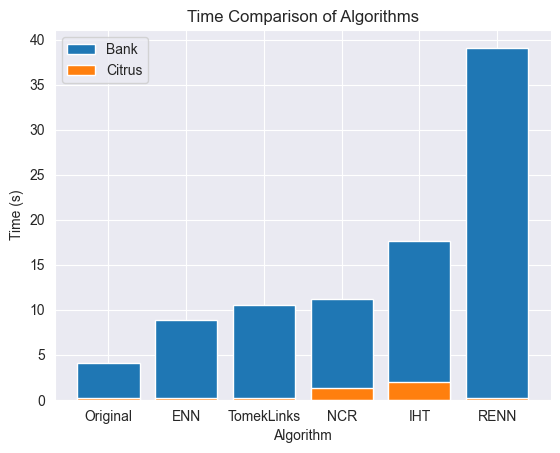

In [508]:
# Create a bar chart of the times for each algorithm for the csgo dataset
plt.bar(results_bank['algorithm'], results_bank['time'], label='Bank')

# Create a bar chart of the times for each algorithm for the citrus dataset
plt.bar(results_citrus['algorithm'], results_citrus['time'], label='Citrus')

# Set the x-axis label and title
plt.xlabel('Algorithm')
plt.ylabel('Time (s)')
plt.title('Time Comparison of Algorithms')

# Add a legend
plt.legend()

# Display the bar chart
plt.show()

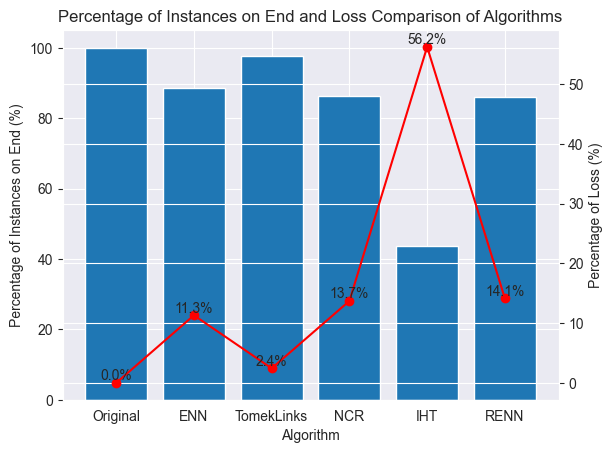

In [509]:
# Create a bar chart of the percentage of instances on end for each algorithm
fig, ax1 = plt.subplots()

ax1.bar(results_bank['algorithm'], results_bank['percentage_instances_end'])
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Percentage of Instances on End (%)')
ax1.set_title('Percentage of Instances on End and Loss Comparison of Algorithms')

# Create a second axis on the right side for percentage loss
ax2 = ax1.twinx()

# Calculate the percentage loss
percentage_loss = 100 - results_bank['percentage_instances_end']

# Plot the percentage loss and write the percentage text next to each point
for i, loss in enumerate(percentage_loss):
    ax2.text(i, loss, f'{loss:.1f}%', ha='center', va='bottom')

ax2.plot(results_bank['algorithm'], percentage_loss, color='red', marker='o')
ax2.set_ylabel('Percentage of Loss (%)')

# Display the bar chart
plt.show()

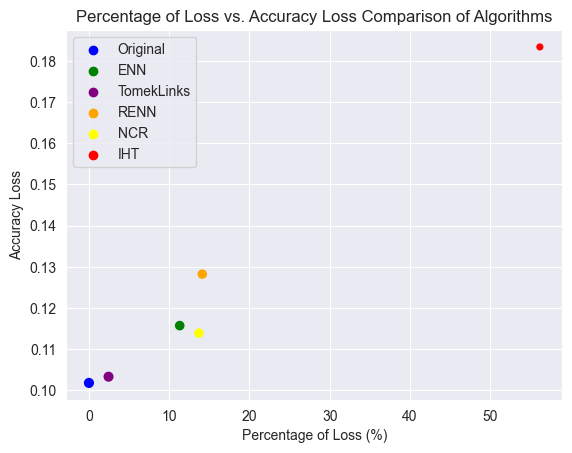

In [510]:
# Calculate the percentage loss and accuracy loss
percentage_loss = 100 - results_bank['percentage_instances_end']
accuracy_loss = 1 - results_bank['accuracy']

# Create a color map for the algorithms
colors = {'Original': 'blue', 'ENN': 'green', 'TomekLinks': 'purple', 'RENN': 'orange', "NCR":'yellow', "IHT": 'red'}

# Create a scatter plot of percentage loss vs. accuracy loss
plt.scatter(percentage_loss, accuracy_loss, c=results_bank['algorithm'].apply(lambda x: colors[x]), 
            s=results_bank['num_instances_end']/1000)
plt.xlabel('Percentage of Loss (%)')
plt.ylabel('Accuracy Loss')
plt.title('Percentage of Loss vs. Accuracy Loss Comparison of Algorithms')

# Add a legend for the colors
for algorithm in colors:
    plt.scatter([], [], c=colors[algorithm], label=algorithm)
plt.legend()

# Display the scatter plot
plt.show()

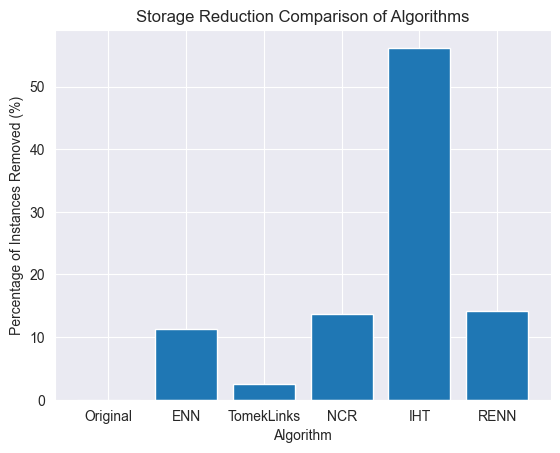

In [511]:
# Calculate the number of instances removed by each algorithm
results_bank['num_instances_removed'] = results_bank['num_instances_start'] - results_bank['num_instances_end']

# Calculate the percentage of instances removed by each algorithm
results_bank['percentage_reduction'] = (results_bank['num_instances_removed'] / results_bank['num_instances_start']) * 100

# Create a bar chart showing the percentage of instances removed by each algorithm
plt.bar(results_bank['algorithm'], results_bank['percentage_reduction'])
plt.xlabel('Algorithm')
plt.ylabel('Percentage of Instances Removed (%)')
plt.title('Storage Reduction Comparison of Algorithms')
plt.show()

### ENN + PCA

In [512]:
from sklearn.decomposition import PCA
from imblearn.under_sampling import EditedNearestNeighbours

def evaluate_under_sampling_techniqueX(X, y):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply ENN to the train set
    enn = EditedNearestNeighbours()
    X_train_resampled, y_train_resampled = enn.fit_resample(X_train, y_train)
    
    # Perform PCA on the resampled data
    pca = PCA(n_components=3)
    X_train_pca = pca.fit_transform(X_train_resampled)
    print("Shape of transformed data after PCA:", X_train_pca.shape)
    
    # Train a k-NN classifier and evaluate the results
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_pca, y_train_resampled)
    y_pred = knn.predict(pca.transform(X_test))
    
    # Compute and return the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

evaluate_under_sampling_techniqueX(X_bank, y_bank)


Shape of transformed data after PCA: (33701, 3)


0.8512913640032284

In [513]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

def evaluate_under_sampling_techniqueX(X, y):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply NCR to the train set
    ncr = NeighbourhoodCleaningRule()
    X_train_resampled, y_train_resampled = ncr.fit_resample(X_train, y_train)
    
    # Perform PCA on the resampled data
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_resampled)
    print("Shape of transformed data after PCA:", X_train_pca.shape)
    
    # Train a k-NN classifier and evaluate the results
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_pca, y_train_resampled)
    y_pred = knn.predict(pca.transform(X_test))
    
    # Compute and return the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

evaluate_under_sampling_techniqueX(X_bank, y_bank)


Shape of transformed data after PCA: (33743, 51)


0.8568401937046005

In [514]:
# Get the memory usage in bytes
memory_usage = df_bank.memory_usage(deep=True).sum()

# Convert to megabytes
memory_usage_mb = memory_usage / (1024 * 1024)

print("Memory usage:", memory_usage_mb, "MB")

Memory usage: 28.223767280578613 MB


Finding 60 most important features

In [515]:
from sklearn.feature_selection import SelectKBest, f_classif

# Define the number of top features to select
k = 60

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(bank_data.drop('Target', axis=1), bank_data['Target'], test_size=0.2, random_state=42)

# Feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=k)
X_train = selector.fit_transform(X_train, y_train)

# Train a k-NN classifier and evaluate the results
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
X_test = selector.transform(X_test)
y_pred = knn.predict(X_test)

# Compute and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the selected top k features
top_k_indices = selector.get_support(indices=True)
top_k_features = bank_data.drop('Target', axis=1).columns[top_k_indices]
print("Top", k, "features:", top_k_features)


C:\Users\Admin\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=60 is greater than n_features=51. All the features will be returned.
  warnings.warn(


Accuracy: 0.8818603712671509
Top 60 features: Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age', 'balance', 'day', 'duration', 'campaign',
       'pdays', 'previous'],
      dtype='object')


In [516]:
selected_features_df = bank_data[top_k_features.tolist() + ['Target']]
selected_features_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous,Target
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,58,2143,5,261,1,-1,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,44,29,5,151,1,-1,0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,33,2,5,76,1,-1,0,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,47,1506,5,92,1,-1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,33,1,5,198,1,-1,0,0


In [517]:
# Get the memory usage in bytes
memory_usage = selected_features_df.memory_usage(deep=True).sum()

# Convert to megabytes
memory_usage_mb = memory_usage / (1024 * 1024)

print("Memory usage:", memory_usage_mb, "MB")

Memory usage: 19.66080093383789 MB


In [518]:
X = selected_features_df.drop(['Target'], axis=1)
y = selected_features_df['Target']
results_ENN, resulting_dataset_ENN = evaluate_under_sampling_technique(X, y, "ENN")
results_bank = pd.concat([results_ENN, results_bank], axis=0)
results_ENN.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
ENN,8.883326,0.884282,0.892186,0.884282,0.88781,39645.0,35160.0,88.687098,3058.0,2858.0


In [519]:
X = selected_features_df.drop(['Target'], axis=1)
y = selected_features_df['Target']
results_ENN, resulting_dataset_ENN = evaluate_under_sampling_technique(X, y, "NCR")
results_csgo = pd.concat([results_ENN,results_bank], axis=0)
results_ENN.head(10)

,time,accuracy,precision,recall,f1-score,num_instances_start,num_instances_end,percentage_instances_end,num_duplicated_start,num_duplicated_end
NCR,12.916066,0.886098,0.892402,0.886098,0.888965,39645.0,34209.0,86.288309,3058.0,2703.0


In [520]:
# Drop duplicate rows in selected_features_df
selected_features_df.drop_duplicates(inplace=True)

# Count the number of duplicate rows that were dropped
num_duplicates = selected_features_df.duplicated().sum()
finalDF=selected_features_df.copy()
# Print the number of duplicate rows
print(f"Dropped {num_duplicates} duplicate rows.")


Dropped 0 duplicate rows.


In [521]:
# Get the memory usage in bytes
memory_usage = finalDF.memory_usage(deep=True).sum()

# Convert to megabytes
memory_usage_mb = memory_usage / (1024 * 1024)

print("Memory usage:", memory_usage_mb, "MB")

Memory usage: 18.28142547607422 MB


In [522]:
# Check the class balance of the target variable
print(finalDF['Target'].value_counts())

Target
0    39922
1     5289
Name: count, dtype: int64


In [523]:
# Define the features and target variable
features = finalDF.drop('Target', axis=1)
target = finalDF['Target']
X_scaled = StandardScaler().fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.2, random_state=42)

# Balance the classes using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [524]:
print("Showing the final shape of the dataset")
X_resampled.shape

Showing the final shape of the dataset


(56593, 51)

In [525]:
# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.89      7987
           1       0.37      0.73      0.49      1056

    accuracy                           0.82      9043
   macro avg       0.66      0.78      0.69      9043
weighted avg       0.89      0.82      0.85      9043



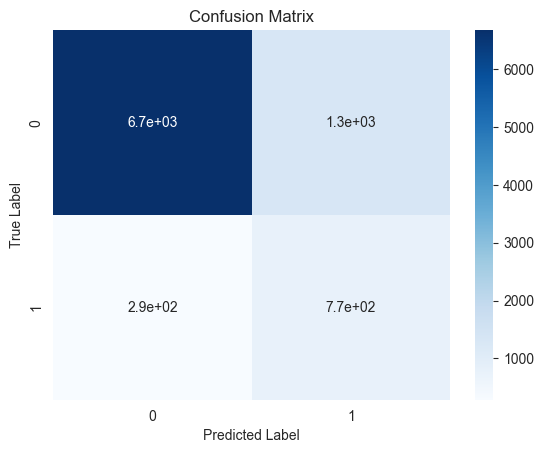

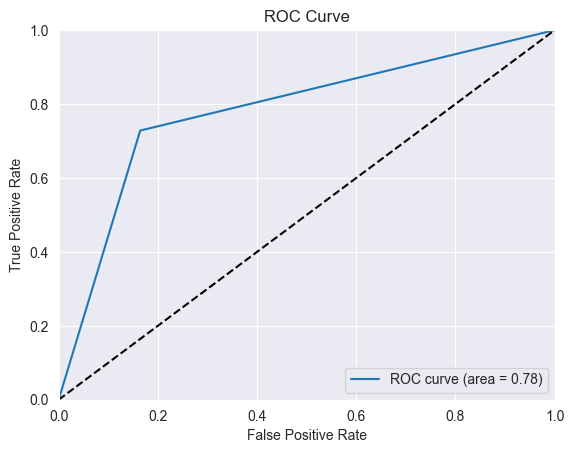

In [526]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot the ROC curve and calculate the AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()